In [130]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import special as spc
%matplotlib inline
##############################################################
nmax = 3
msteps = 200
##############################################################
EULER = 2.71828182845904523536028747135266249775724709369995
pi = 3.14159265358979323846264338327950288419716939937510
eee = -4.803204673e-10
##############################################################
eps,eps1,eps2 =1.0,25.0,25.0
a1r,a2r = 10.0e-4,10.0e-4
q1r = 1000.0
k_d = 1000.0
##############################################################
a1 = k_d * a1r
a2 = k_d * a2r
q1 = q1r * eee
q2 = q1 * a2r / a1r
q1inf = q1 * (1. + a1)
q2inf = q2 * (1. + a2)
##############################################################
L_min = 1.e-6 #**(-6)
L_max = 1. #**(-1)

## calculations in plasma functions

### get polynoms

In [131]:
def getQ(nmax):
    q = np.zeros((nmax,nmax))
    for n in range(nmax):
        #tmp = spc.legendre(n,[])
        for i in range(nmax):
            q[n,i] = spc.legendre(n,[])[i]
    return q

In [132]:
def getG(nmax):
    g = np.zeros((nmax,nmax,nmax))
    for alpha in range(nmax):
        alpha_tmp = alpha + 0.5
        for n in range(nmax):  
            tmp = spc.gegenbauer(n,alpha_tmp,[])
            for i in range(nmax):
                g[alpha,n,i] = tmp[i]
    return g

In [133]:
def getP(nmax):
    p = np.zeros((nmax,nmax))
    for k in range(nmax):
        for m in range(k//2+1):       
            m2 = spc.factorial2(2*m, exact = True) * 1.0
            kkk = spc.factorial(k, exact = True) * 1.0
            k2_1_2m = spc.factorial2(2*k + 1 - 2*m, exact = True) * 1.0
            p[k,k-2*m] = kkk * (2.0*k + 1.0 - 4.0*m) /m2/k2_1_2m
    return p

In [134]:
def getH(q,g,p,nmax):
    #global nmax
    h = np.zeros((nmax,nmax,nmax,nmax))
    for m in range(nmax):
        for l in range(nmax-m):
            for k in range(nmax-m-l):
                for i in range(k+1):
                    for j in range(l+1):
                        for n in range(i+j+1):
                            h[k,m,l,n] += q[k,i] * g[m,l,j] * p[i+j,n]
    return h

### get matrix 

In [135]:
def getAlphaI(epsi,ai,constantCharge,nmax):
    global eps#,nmax
    alpha_i = np.zeros(nmax)
    if constantCharge:
        for i in range(nmax):
            v = i + 1.5
            alpha_i[i] = eps*spc.kv(v,ai)/np.sqrt(ai)
            v = i + 0.5
            alpha_i[i] += i*(epsi-eps)*spc.kv(v,ai)/(ai**1.5)
        return alpha_i
    else:
        for i in range(nmax):
            v = i + 0.5
            alpha_i[i] = spc.kv(v,ai)/ai**0.5
        return alpha_i

In [136]:
def getBi(ai,R,h,nmax):
    global pi#, nmax
    b_nm_i = np.zeros((nmax,nmax))
    for n in range(nmax):                      
        for m in range(nmax):
            tmp = 0.0
            for l in range(nmax - m):
                for k in range(m+1):
                    vu = np.float64(m+l+0.5)
                    tmp1 = np.sqrt(pi/2.) * 2. * vu * spc.kv(vu,R) * spc.iv(vu,ai)/R**(k+0.5)/ai**(m-k+0.5)
                    tmp += h[k,m,l,n] * (-1.)**k * spc.comb(m,k) * tmp1
                    df2m = spc.factorial2(2*m-1,exact=True) * 1.0
            b_nm_i[n,m] = tmp * df2m
    return b_nm_i    

In [137]:
def getDBi(ai,R,h,nmax):
    global pi#,nmax
    db_nm_i = np.zeros((nmax,nmax))
    for n in range(nmax):                      # nmax = 7
        for m in range(nmax):
            tmp = 0.0
            for l in range(nmax - m):
                for k in range(m+1):
                    vu = np.float64(m+l+0.5)
                    tmp1 = spc.kv(vu,R) * (spc.ivp(vu,ai)-spc.iv(vu,ai)*(m-k+0.5)/ai)
                    tmp2 = np.sqrt(pi/2.) * vu * 2. * tmp1 / R**(k+0.5) / ai**(m-k+0.5)
                    tmp += h[k,m,l,n] * (-1.)**k * spc.comb(m,k) * tmp2
            df2m = spc.factorial2(2*m-1,exact=True) * 1.0
            db_nm_i[n,m] = tmp * df2m
    return db_nm_i

In [138]:
def getBettai(ai,epsi,b_nm,db_nm,constantCharge,nmax):
    global eps#,nmax
    betta = np.zeros((nmax,nmax))
    if constantCharge:
        for n in range(nmax):
            for m in range(nmax):
                betta[n,m] = epsi * n / ai * b_nm[n,m] - eps * db_nm[n,m]
        return betta
    else:
        betta = b_nm
        return betta

In [139]:
def getMatrix(betta_1,betta_2,alpha_1,alpha_2,nmax):
    #global nmax
    matrix = np.zeros((2*nmax,2*nmax))
    for n in range(nmax):
        matrix[n,n] = alpha_1[n]
        matrix[nmax+n,nmax+n] = alpha_2[n]
        for m in range(nmax):
            matrix[n,nmax+m] += betta_1[n,m]
            matrix[nmax+n,m] += betta_2[n,m]
    return matrix

In [140]:
def getFrMem(constantCharge,a1,a2,q1,q2,k_d,fi1s,fi2s,nmax):
    #global k_d,q1,q2,a1,a1#,nmax
    free_member = np.zeros(2*nmax)
    if constantCharge:
        free_member[0] = k_d*q1/(a1**2)
        free_member[nmax] = k_d*q2/(a2**2)
        return free_member
    else:
        free_member[0] = fi1s
        free_member[nmax] = fi2s
        return free_member

### get force

In [141]:
def getKsi(series_coefficient,ai,b_nm_i,d_b_nm_i,nmax):
    #global nmax
    ksi = np.zeros(nmax)
    for n in range(nmax):
        ksi[n] = series_coefficient[n] * n * spc.kv(n+0.5,ai) / np.sqrt(ai)
        ksi[n] -= series_coefficient[n]  * spc.kv(n+1.5,ai) * np.sqrt(ai)
        for m in range(nmax):
            ksi[n] += series_coefficient[nmax+m]*ai*d_b_nm_i[n,m]
    return ksi

In [142]:
def getPsi(series_coefficient,ai,b_nm_i,d_b_nm_i,nmax):
    #global nmax
    psi = np.zeros(nmax)
    for n in range(nmax):
        psi[n] = series_coefficient[n] * spc.kv(n+0.5,ai) / np.sqrt(ai)
        for m in range(nmax):
            psi[n] += series_coefficient[nmax+m] * b_nm_i[n,m]  
    return psi

In [143]:
def getForce19(ksi,psi,nmax):
    #global nmax
    f19 = np.float64(0)
    for n in range(1,nmax):
        tmp = ksi[n-1] - np.float64(n-1) * psi[n-1]
        f19 += np.float64(n) / ((2*n - 1) * (2*n + 1)) * (ksi[n] + (n + 1) * psi[n]) *tmp
    f19 *= eps
    return f19

### capacitance + potential coefficients

In [144]:
def getCapacitance(matrix,dBnm1,dBnm2,fi1s,fi2s,nmax):
    global a1r,a2r,eps,eps1,eps2,k_d#,nmax
    a1 = a1r * k_d
    a2 = a2r * k_d
    C = np.zeros(4)
    # 1st step
    frMem = np.zeros(2*nmax)
    frMem[0] = fi1s
    bb = sp.linalg.lu_factor(matrix)
    seriesCoefficient = sp.linalg.lu_solve(bb,frMem,0)
    Q1 = seriesCoefficient[0] * a1**0.5 * spc.kv(1.5,a1)
    tmp = 0.
    for i in range(nmax):
        tmp += seriesCoefficient[nmax+i] * a1 * dBnm1[0,i]
    Q1 = (Q1 - tmp) * eps * a1r
    Q2 = seriesCoefficient[nmax] * a2**0.5 * spc.kv(1.5,a2)
    tmp = 0.
    for i in range(nmax):
        tmp += seriesCoefficient[i] * a2 * dBnm2[0,i]
    Q2 = (Q2 - tmp) * eps * a2r
    C[0] = Q1 / fi1s
    C[1] = Q2 / fi1s
     # 2st step
    frMem = np.zeros(2*nmax)
    frMem[nmax] = fi2s
    bb = sp.linalg.lu_factor(matrix)
    seriesCoefficient = sp.linalg.lu_solve(bb,frMem,0)
    Q1 = seriesCoefficient[0] * a1**0.5 * spc.kv(1.5,a1)
    tmp = 0.
    for i in range(nmax):
        tmp += seriesCoefficient[nmax+i] * a1 * dBnm1[0,i]
    Q1 = (Q1 - tmp) * eps * a1r
    Q2 = seriesCoefficient[nmax] * a2**0.5 * spc.kv(1.5,a2)
    tmp = 0.
    for i in range(nmax):
        tmp += seriesCoefficient[i] * a2 * dBnm2[0,i]
    Q2 = (Q2 - tmp) * eps * a2r
    C[2] = Q1 / fi2s
    C[3] = Q2 / fi2s
    return C

In [145]:
def getPpotential(matrix,Bnm1,Bnm2,q1,q2,nmax):
    global a1r,a2r,eps,eps1,eps2,k_d#,nmax
    a1 = a1r * k_d
    a2 = a2r * k_d
    S = np.zeros(4)
    frMem = np.zeros(2*nmax)
    frMem[0] = k_d*q1/(a1**2)
    bb = sp.linalg.lu_factor(matrix)
    seriesCoefficient = sp.linalg.lu_solve(bb,frMem,0)
    fi1s = seriesCoefficient[0] * spc.kv(0.5,a1) / a1**0.5
    fi2s = seriesCoefficient[nmax] * spc.kv(0.5,a2) / a2**0.5
    for i in range(nmax):
        fi1s += seriesCoefficient[nmax+i] * Bnm1[0,i]
        fi2s += seriesCoefficient[i] * Bnm2[0,i]
    S[0] = fi1s / q1
    S[1] = fi2s / q1
    frMem = np.zeros(2*nmax)
    frMem[nmax] = k_d*q2/(a2**2)
    bb = sp.linalg.lu_factor(matrix)
    seriesCoefficient = sp.linalg.lu_solve(bb,frMem,0)
    fi1s = seriesCoefficient[0] * spc.kv(0.5,a1) / a1**0.5
    fi2s = seriesCoefficient[nmax] * spc.kv(0.5,a2) / a2**0.5
    for i in range(nmax):
        fi1s += seriesCoefficient[nmax+i] * Bnm1[0,i]
        fi2s += seriesCoefficient[i] * Bnm2[0,i]
    S[2] = fi1s / q2
    S[3] = fi2s / q2
    return S

### get force data in plasma

In [146]:
def getForcePlasma(constantCharge,a1r,a2r,q1r,k_d):
    global EULER,pi,eee,L_min,L_max,eps1,eps2,eps,nmax,msteps
    a1 = k_d * a1r
    a2 = k_d * a2r
    
    q1 = q1r * eee
    q2 = q1 * a2r / a1r
    
    q1inf = q1 * (1. + a1)
    q2inf = q2 * (1. + a2)
    
    fi1s = q1inf * k_d / a1 / (1.+a1)
    fi2s = q2inf * k_d / a2 / (1.+a2)
    
    if msteps == 1:
        dL = 1.0
    else:
        dL = np.exp(np.log((L_max/L_min))/(msteps-1.))
    LL = L_min/dL
    
    p = getP(nmax)
    g = getG(nmax)
    q = getQ(nmax)
    h = getH(q,g,p,nmax)
    alpha1 = getAlphaI(eps1,a1,constantCharge,nmax)
    alpha2 = getAlphaI(eps2,a2,constantCharge,nmax)
    forceData = np.zeros((2,msteps))
    capacitanceData = np.zeros((5,msteps))
    #t1 = time.time()
    for steps in range(msteps):
        LL *= dL
        Rr = a1r + a2r + LL
        R = Rr * k_d
        # series coefficients
        Bnm1 = getBi(a1,R,h,nmax)
        Bnm2 = getBi(a2,R,h,nmax)
        dBnm1 = getDBi(a1,R,h,nmax)
        dBnm2 = getDBi(a2,R,h,nmax)
        # coefficients for system
        betta1 = getBettai(a1,eps1,Bnm1,dBnm1,constantCharge,nmax)
        betta2 = getBettai(a2,eps2,Bnm2,dBnm2,constantCharge,nmax)
        # linear system
        matrix = getMatrix(betta1,betta2,alpha1,alpha2,nmax)
        fr_mem = getFrMem(constantCharge,a1,a2,q1,q2,k_d,fi1s,fi2s,nmax)
        # capacitance
        if constantCharge:
            Potential = getPpotential(matrix,Bnm1,Bnm2,q1,q2,nmax)
        else:
            Capacitance = getCapacitance(matrix,dBnm1,dBnm2,fi1s,fi2s,nmax)
        # LU decomp
        bb = sp.linalg.lu_factor(matrix)
        series_coefficient = sp.linalg.lu_solve(bb,fr_mem,0)
        ksi1 = getKsi(series_coefficient,a1,Bnm1,dBnm1,nmax)
        psi1 = getPsi(series_coefficient,a1,Bnm1,dBnm1,nmax)
        f_qul = q1 * q2 / Rr**2
        f_dlvo = q1inf * q2inf / (1.+a1) / (1.+a2) * np.exp(a1+a2-R)*(1.+R)/Rr**2
        if constantCharge:
            normalized_force_19 = getForce19(ksi1,psi1,nmax)/f_qul
        else:
            normalized_force_19 = getForce19(ksi1,psi1,nmax)/f_dlvo
        forceData[0,steps],forceData[1,steps] = LL,-normalized_force_19
        if not constantCharge:
            capacitanceData[0,steps]=LL
            for i in range(1,5):
                capacitanceData[i,steps]=Capacitance[i-1]
        
    #t2 = time.time()
    return forceData#,t2-t1,capacitanceData

## calculation in vacuum functions

In [147]:
def getMatrixMandN(R,nmax):
    global a1r,a2r#,nmax
    Mnk, Nnk = np.zeros((nmax,nmax)), np.zeros((nmax,nmax))
    for n in range(nmax):
        for k in range(nmax):
            Mnk[n,k] = -spc.comb(n+k,n) * a1r**(n+1) * a2r**k / R**(n+k+1)
            Nnk[n,k] = -spc.comb(n+k,n) * a1r**k * a2r**(n+1) / R**(n+k+1)
    return Mnk,Nnk

In [148]:
def getFandG(R,fi1s,fi2s,nmax):
    global a1r,a2r,q1,q2#,nmax
    f,g = np.zeros(nmax),np.zeros(nmax)
    #for n in range(nmax):
    #    f[n] = (a1r/R)**(n+1) * q2
    #    g[n] = (a2r/R)**(n+1) * q1
    f[0] = fi1s * a1r
    g[0] = fi2s * a2r
    return f,g

In [149]:
def getCn(series,R,nmax):
    global a1r,a2r#,nmax
    Cn = np.zeros(nmax)
    Cn[0] = series[0]/a1r
    for n in range(1,nmax):
        Cn[n] = series[n]*(n+1.)/a1r
        tmp = 0.
        for k in range(nmax):
            tmp += series[nmax+k]*spc.comb(n+k,k)*n * a1r**n * a2r**k / R**(n+k+1.)
        Cn[n] -= tmp
    return Cn

In [150]:
def getForceVac(Cn,nmax):
    global eps#,nmax
    tmp = 0.
    for n in range(nmax-1):
        tmp += Cn[0] * Cn[n+1] * (n+1.) / (2.*n+1.) / (2.*n+3.)
    return eps*tmp

In [151]:
def getForceVacuum(a1r,a2r,q1r):
    global L_min,L_max,eee,pl,euler,nmax,eps
    
    q1 = q1r * eee
    
    q2 = q1 * a2r / a1r
    fi1s = q1 / a1r 
    fi2s = q2 / a2r
    if msteps == 1:
        dL = 1.0
    else:
        dL = np.exp(np.log((L_max/L_min))/(msteps-1.))
    LL = L_min/dL    
    
    forceData = np.zeros((2,msteps))
        
    for step in range(msteps):
        
        LL *= dL
        R = a1r + a2r + LL
        
        M, N = getMatrixMandN(R,nmax)
        f, g = getFandG(R,fi1s,fi2s,nmax)
        
        matrix = np.matmul(M,N) - np.eye(nmax)
        frMem = np.matmul(M,g) + f
       
        bb = sp.linalg.lu_factor(matrix)
        aaa = sp.linalg.lu_solve(bb,frMem,0)
        
        aaa1 = np.linalg.solve(matrix,frMem)
        
        #print sp.linalg.norm(matrix,np.inf) * sp.linalg.norm(sp.linalg.inv(matrix),np.inf)
        
        bbb = np.matmul(N,aaa) - g
        
        series = aaa
        series = np.append(series,bbb)

        Cn = getCn(series,R,nmax)
        
        f_qul = q1 * q2 / R**2
        
        forceData[0,step] = LL
        forceData[1,step] = -getForceVac(Cn,nmax) / f_qul
        
    return forceData

In [152]:
def drawForcePlot(forceData):
    p1 = plt.plot(forceData[0],forceData[1])
    plt.xscale('log')
    plt.grid()
    plt.title('Force depending on distance')
    plt.xlabel('L(cm)')
    plt.ylabel('$F_{1z} R^{2} / q_1 q_2$')
    plt.show()

In [167]:
def drawComparing(forceDataPl,forceDataVc,string):
    p1 = plt.plot(forceDataPl[0],forceDataPl[1], label='plasma')
    p2 = plt.plot(forceDataVc[0],forceDataVc[1], label='vacuum')
    plt.xscale('log')
    plt.grid()
    plt.title('Comparing Force'+' ' + string, fontsize=12)
    plt.xlabel('L(cm)')
    plt.ylabel('$F_{1z,normalized}$', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [154]:
def drawForces4(forceData_10_10_100_100,forceData_1_10_100_100):
    fig, axs = plt.subplots(4, figsize = (9,12))

    axs[0].plot(forceData_10_10_100_100[0],forceData_10_10_100_100[1],)
    axs[0].set_title('Constant Potential $a_1=10,a_2=10$', fontsize=12)
    axs[0].set_xscale('log')
    axs[0].grid()
    axs[0].set_xlabel('L(cm)', fontsize=12)
    axs[0].set_ylabel('$F_{1z}/ F_{DLVO}$', fontsize=12)
    
    axs[1].plot(forceData_10_10_100_100[0],forceData_10_10_100_100[2],)
    axs[1].set_title('Constant Potential $a_1=10,a_2=10$', fontsize=12)
    axs[1].set_xscale('log')
    axs[1].grid()
    axs[1].set_xlabel('L(cm)', fontsize=12)
    axs[1].set_ylabel('$F_{2z}/ F_{DLVO}$', fontsize=12)

    axs[2].plot(forceData_1_10_100_100[0],forceData_1_10_100_100[1])
    axs[2].set_title('Constant Potential $a_1=1,a_2=10$', fontsize=12)
    axs[2].set_xscale('log')
    axs[2].grid()
    axs[2].set_xlabel('L(cm)', fontsize=12)
    axs[2].set_ylabel('$F_{1z}/ F_{DLVO}$', fontsize=12)

    axs[3].plot(forceData_1_10_100_100[0],forceData_1_10_100_100[2])
    axs[3].set_title('Constant Potential $a_1=1,a_2=10$', fontsize=12)
    axs[3].set_xscale('log')
    axs[3].grid()
    axs[3].set_xlabel('L(cm)', fontsize=12)
    axs[3].set_ylabel('$F_{2z}/ F_{DLVO}$', fontsize=12)

    fig.tight_layout()
    #fig.figsize = (6,17)
    plt.show()

## plots

In [178]:
k_d = 500.0

t1 = time.time()
a1r,a2r = 10.0e-4,10.0e-4
str1 = '$a_1=$' + str(a1r*1.e4) + 'mcm' + ' '+ '$a_2=$' + str(a2r*1.e4) + 'mcm'
forcePlasma_10_10 = getForcePlasma(False,a1r,a2r,q1r,k_d)
t2 = time.time()
forceVac_10_10 = getForceVacuum(a1r,a2r,q1r)
t3 = time.time()
a1r,a2r = 10.0e-5,10.0e-4
str2 = '$a_1=$' + str(a1r*1.e4) + 'mcm' + ' '+ '$a_2=$' + str(a2r*1.e4) + 'mcm'
forcePlasma_1_10 = getForcePlasma(False,a1r,a2r,q1r,k_d)
t4 = time.time()
forceVac_1_10 = getForceVacuum(a1r,a2r,q1r)
t5 = time.time()
print 'time pl', 'time vac'
print t2-t1, t3-t2
print t4-t3, t5-t4

time pl time vac
0.660000085831 0.0599999427795
0.641000032425 0.0620000362396


k_d= 500.0


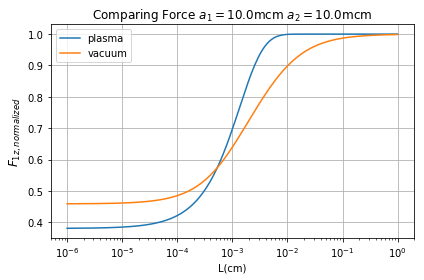

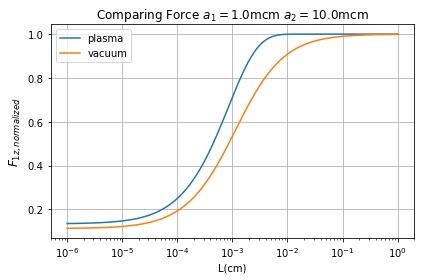

In [179]:
print 'k_d=',k_d
drawComparing(forcePlasma_10_10,forceVac_10_10,str1)
drawComparing(forcePlasma_1_10,forceVac_1_10,str2)